<a href="https://colab.research.google.com/github/Lor3nzoVis3/DeepLearning_ProjectLV_GB/blob/master/TransferLearningV3_faceOrientation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
"""
@author: LorenzoVisentini
"""

modelName = "InceptionV3"

#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
#keras
import keras
from keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling2D, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
#inception v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [47]:
#Images parameters
img_width = 299
img_height = 299

# train_dir = './source_light/training'
# validation_dir = './source_light/validation' 
train_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/train'
validation_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/valid' 

batch_size = 64
epochs = 20

In [48]:
#from https://edebrouwer.github.io/deeplearning/carvision/transfer/neural/networks/learning/2017/08/05/TransferLearning.html

#Transfer learning on InceptionV3 model
#use all the layers except for the last fully connected layer (because its 
#specific to the ImageNet competition)
#we will retrain layers with new inputs
pre_trained_model = InceptionV3(input_shape = (img_height, img_width, 3),
                               include_top = False, #exclude last flatten layer
                               weights = 'imagenet' #weights from imageNet
                               ) 

# pre_trained_model.summary() #check V3 structure

In [49]:
from keras import backend as K
n_classes = 3

#transfer learning phase
x = pre_trained_model.output

x = GlobalMaxPooling2D()(x)
x = Dropout(rate = 0.7)(x)

x = Dense(512, activation= 'relu')(x) #add fully connected layer
x = BatchNormalization()(x)

x = Dense(n_classes, activation= 'softmax')(x)
model = Model(inputs = pre_trained_model.input, outputs = x)

#freeze the model excepted added layers
#freeze the model excepted added layers
#because of BN normalization problem: https://github.com/keras-team/keras/issues/9214
for layer in pre_trained_model.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
            layer.trainable = True
            K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
            K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False

opt = optimizers.Adam(learning_rate=0.002)
model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',  #because we have 3 possible outputs
              metrics = ['accuracy'])

In [50]:
#preprocessing
datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

val_generator = datagen.flow_from_directory(directory=validation_dir,
                                                    target_size=(img_height, img_width),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

Found 8383 images belonging to 3 classes.
Found 1811 images belonging to 3 classes.


In [51]:
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = train_generator.n//batch_size,
                             epochs = epochs,
                             validation_data = val_generator,
                             validation_steps=val_generator.n//batch_size
                             )

Epoch 1/20
130/130 [==============================] - 51s 389ms/step - loss: 1.1873 - accuracy: 0.5310 - val_loss: 1.8307 - val_accuracy: 0.2310
Epoch 2/20
130/130 [==============================] - 49s 380ms/step - loss: 0.8873 - accuracy: 0.6025 - val_loss: 0.8837 - val_accuracy: 0.5988
Epoch 3/20
130/130 [==============================] - 50s 381ms/step - loss: 0.8202 - accuracy: 0.6379 - val_loss: 0.8337 - val_accuracy: 0.6384
Epoch 4/20
130/130 [==============================] - 49s 380ms/step - loss: 0.7571 - accuracy: 0.6748 - val_loss: 0.7537 - val_accuracy: 0.6998
Epoch 5/20
130/130 [==============================] - 49s 380ms/step - loss: 0.6982 - accuracy: 0.7109 - val_loss: 0.6727 - val_accuracy: 0.7360
Epoch 6/20
130/130 [==============================] - 50s 381ms/step - loss: 0.5788 - accuracy: 0.7771 - val_loss: 0.5278 - val_accuracy: 0.8075
Epoch 7/20
130/130 [==============================] - 49s 378ms/step - loss: 0.4555 - accuracy: 0.8347 - val_loss: 0.4898 - val_ac

In [9]:
#save model and history
file_model = '/content/drive/My Drive/Deep Learning Project - Image Classification/Models/'+ 'FaceOrientationpostPatch' + modelName + '_' + str(batch_size) + '_' + str(epochs)
model.save(file_model + '.h5')
print(file_model)
#save history
file_hist = '/content/drive/My Drive/Deep Learning Project - Image Classification/History/'+ 'FaceOrientationpostPatch' + modelName + '_' + str(batch_size) + '_' + str(epochs) + '.csv'
df_history = pd.DataFrame(history.history)
with open(file_hist, 'w') as file:
    df_history.to_csv(file)

/content/drive/My Drive/Deep Learning Project - Image Classification/Models/FaceOrientationpostPatchInceptionV3_64_20


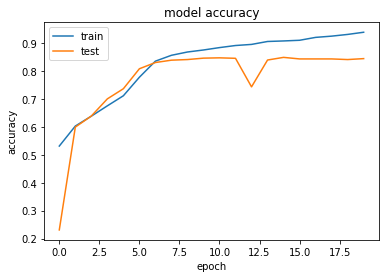

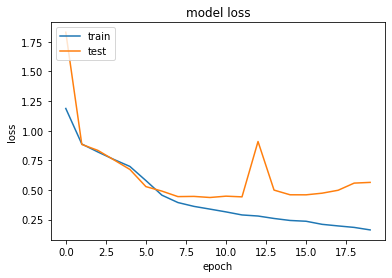

In [52]:
#plot results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#evaluation
# https://stackoverflow.com/questions/40564936/keras-what-is-the-difference-between-model-evaluate-generator-and-model-predict
steps = val_generator.n // val_generator.batch_size

accuracy_ontest = model.evaluate_generator(val_generator, steps)
predictions_ontest = model.predict_generator(val_generator, steps)
print(accuracy_ontest)
print(predictions_ontest)

[1.4336895942687988, 0.5574776530265808]
[[0.81515956 0.05940105 0.12543942]
 [0.30922788 0.18068106 0.51009107]
 [0.6954961  0.1510021  0.15350184]
 ...
 [0.1459482  0.20645332 0.6475985 ]
 [0.05147425 0.32250583 0.6260199 ]
 [0.98905283 0.00117494 0.00977223]]
